Compare Random Forest, SVM and other models (using Lazy Predict)
Learn about various classification models:
https://scikit-learn.org/stable/supervised_learning.html

Apply models to the Cell Line and TCGA datasets:
https://raw.githubusercontent.com/PineBiotech/omicslogic/master/NormFilt_RiskFactor1_train.txt

https://raw.githubusercontent.com/PineBiotech/omicslogic/master/CellLines_52samples_ExprData_T1.txt


Learn about accuracy metrics, feature selection, and interpretation of model results.

##First, we prepare by loading packages and data used in this notebook

In [ ]:
#@title Prepare Packages and Data {run: "auto"}
#@markdown Here we will use a dataset from cancer patients with Hepatocellular Carcinoma: `The Cancer Genome Atlas`, (see [TCGA](https://portal.gdc.cancer.gov/)). <br>
#@markdown ![The Cancer Genome Atlas](https://docs.gdc.cancer.gov/Data_Portal/Users_Guide/images/GDC-Home-Page.png "TCGA") <br> 
#@markdown To learn more, visit [OmicsLogic](https://learn.omicslogic.com/) <br>

#import pandas and numpy
import pandas as pd
import numpy as np

#import standard classification tools from sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools

# initially SVM is a binary (two classes) classifier
# so by default multiclass problems are handled according to a "one-vs-one" scheme.
# if you want to try OneVsRest scheme - you can use OneVsRestClassifier from sklearn as a wrapper around SVC.
# import model class (SVC stands for Support Vector Classification)
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import scale
import warnings

#import tools for ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

#visualization
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

template = 'ggplot2'
test_size = 0.3

data = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/NormFilt_RiskFactor1_train.txt',sep='\t',header=(0))

#prepare data
features = data.iloc[1:, 0].values
data=data.drop(['ID'], axis = 1) 
dataT = np.transpose(data)

#X is the data, y is the lables (classes)
X = dataT.iloc[:, 1:].values
y = dataT.iloc[:, 0].values

classes = np.unique(y)
n_classes = len(classes)

class_label= dataT[0]

X = scale(X, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

Classification with Support Vector Machine (linear SVC)

In [ ]:
#@markdown Support Vector Machine: sklearn.svm.SVC (C-Support Vector Classification)
#@markdown 
#@markdown Here we will use a dataset from cancer patients with Hepatocellular Carcinoma:
#@markdown 
#@markdown `The Cancer Genome Atlas`, (see [TCGA](https://portal.gdc.cancer.gov/)).
#@markdown ![Support Vector Machine](https://miro.medium.com/max/500/0*DJ_mGzidt4WqWoVm "SVM GIF")


warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# there are several useful parameters such as:
# C - Regularization parameter. The strength of the regularization.
# kernel - Specifies the kernel type to be used in the algorithm
# we will use a linear kernel, it is the only kernel which allows us to use features selection
model = LinearSVC(C=1.0)
model.fit(X_train, y_train)

# after training we can predict labels for the test samples
predictions = model.predict(X_test)

c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions, output_dict=True)
model_accuracy = accuracy_score(y_test, predictions)

Classification Results

In [ ]:
#@markdown Training Results {run: "auto"} </br>
#@markdown Learn more about each one of these terms here, [OmicsLogic](https:learn.omicslogic.com)).
#@markdown ![Annotation](https://www.tutorialexample.com/wp-content/uploads/2022/01/how-to-compute-accuracy-precision-recall-and-f1-score-in-machine-learning.png "Annotation")


clsf_report = pd.DataFrame(cr).transpose()
clsf_report1 = clsf_report[0:n_classes]

fig = px.bar(clsf_report1, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 

dataT1 = dataT
dataT1 = dataT1.iloc[:,1:len(dataT1.columns)]
dataT1

scaled = StandardScaler() 
scaled.fit(dataT1) 
scaled_data = scaled.transform(dataT1) 

#Run Principal Component Analysis
n_components=4
pca = PCA(n_components) 
pca.fit(scaled_data) 
xpca = pca.transform(scaled_data)

labels = {str(i): f'PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}%' for i in range(n_components)}
template = 'ggplot2'

# x and y given as array_like objects
figPCA2D = px.scatter(xpca, x=0, y=1, color=y, 
                      labels=dataT1.index,
                      hover_name = dataT1.index,
                      title="2D PCA for Labels")
figPCA2D.update_layout(width=1000, height=800, template=template)
figPCA2D.show()

In [ ]:
CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

heat = go.Heatmap(z = CM_df, x=CM_df.index, 
                  y=CM_df.columns, 
                  showscale = False,
                  text=CM_df,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix")
fig.show()

In [ ]:
##ROC Curve
# to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
# for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
y_test_bin_labels = label_binarize(y_test, classes=classes)

# for roc curve we are using predicted proba for our test samples
y_score = model.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

y_onehot = pd.get_dummies(y, columns=model.classes_)

#plot
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_score.shape[1]):
    y_true = y_onehot.iloc[:, i]
    name = f"{y_onehot.columns[i]}"
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=700, height=500,
    template = template,
    title="ROC Curve"
)
fig.show()

In [ ]:
# the weights obtained from svm.coef_ represent the vector coordinates
# which are orthogonal to the hyperplane and their direction indicates the predicted class.
# this is only available in the case of a linear kernel
top_features_count = 20

# we use median of weights from all classes, you can also use np.sum(np.abs(model.coef_, axis=0))
vector_weights = np.median(model.coef_, axis=0)
top_positive_coefficients = np.argsort(vector_weights)[-top_features_count:]
top_negative_coefficients = np.argsort(vector_weights)[:top_features_count]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
top_features, top_features_weights = features[top_coefficients], vector_weights[top_coefficients]

d = {'Features':features[top_coefficients], 'Weight':vector_weights[top_coefficients]}
df_features = pd.DataFrame(d)

#plot feature significance
fig = px.bar(y=df_features.Features, x=df_features.Weight, template=template)
fig.update_layout(width=700, height=1000, template=template, title="Feature Significance")
fig.show()

##New Dataset: cell line breast cancer subtypes

In [ ]:
data = pd.read_table('https://raw.githubusercontent.com/PineBiotech/omicslogic/master/CellLines_52samples_ExprData_T1.txt',sep='\t',header=(0))
features = data.iloc[1:, 0].values

#add the gene id to index column
data.index = data.id

#drop or remove "id" column from the data
data=data.drop(['id'], axis = 1) 

#transpose
dataT = np.transpose(data)

#prepare train and test data
X = dataT.iloc[:, 1:].values
y = dataT.iloc[:, 0].values

#save class names
classes = np.unique(y)
n_classes = len(classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=0)

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#define Random forest model
model = RandomForestClassifier(n_estimators=500, bootstrap=True, verbose=True)

#fit model on training data
model.fit(X_train, y_train)

#Predict test data
predictions = model.predict(X_test)
c_matrix = confusion_matrix(y_test,predictions)
#c_matrix = pd.DataFrame(c_matrix)

CM_df = pd.DataFrame(c_matrix, columns=classes, index=classes)

cr = classification_report(y_test,predictions, output_dict=True)
model_accuracy = accuracy_score(y_test, predictions)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


In [ ]:
clsf_report = pd.DataFrame(cr).transpose()
clsf_report1 = clsf_report[0:n_classes]

fig = px.bar(clsf_report1, barmode='group', template=template)
fig.update_layout(width=700, height=700, template=template, title="Classification Report")
fig.show()

In [ ]:
heat = go.Heatmap(z = c_matrix, x=CM_df.index, 
                  y=CM_df.columns, 
                  showscale = False,
                  text=CM_df,
                  texttemplate="%{text}",
                  textfont={"size":10})
fig = go.Figure(heat)
fig.update_layout(width=700, height=700, template=template, title="Confusion Matrix")
fig.show()

In [ ]:
dataT1 = dataT
dataT1 = dataT1.iloc[:,1:len(dataT1.columns)]
dataT1

scaled = StandardScaler() 
scaled.fit(dataT1) 
scaled_data = scaled.transform(dataT1) 

#Run Principal Component Analysis
n_components=4
pca = PCA(n_components) 
pca.fit(scaled_data) 
xpca = pca.transform(scaled_data)

labels = {str(i): f'PC{i+1}: {pca.explained_variance_ratio_[i]*100:.2f}%' for i in range(n_components)}
template = 'ggplot2'

# x and y given as array_like objects
figPCA2D = px.scatter(xpca, x=0, y=1, color=y, 
                      labels=dataT1.index,
                      hover_name = dataT1.index,
                      title="2D PCA for Labels")
figPCA2D.update_layout(width=1000, height=800, template=template)
figPCA2D.show()

In [ ]:
y_test_bin_labels = label_binarize(y_test, classes=classes)

# for roc curve we are using predicted proba for our test samples
y_score = model.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

y_onehot = pd.get_dummies(y, columns=model.classes_)

#plot
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_score.shape[1]):
    y_true = y_onehot.iloc[:, i]
    name = f"{y_onehot.columns[i]}"
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=700, height=500,
    template = template,
    title="ROC Curve"
)
fig.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


In [ ]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=features)

RF_df = pd.DataFrame(forest_importances.sort_values(ascending=False))
RF_df.columns = ['Feature']

#plot feature significance
fig = px.bar(RF_df[0:20], template=template)
fig.update_layout(width=1000, height=700, template=template, title="Top 20 Features by Significance")
fig.show()

In [ ]:
gene = 'ENSG00000147065'
#plot feature significance
fig = px.bar(y=dataT[gene].astype('float'), x=dataT.index, color=dataT['class'], template=template)
fig.update_layout(width=1000, height=700, template=template, title=("Feature: " + gene))
fig.show()

In [ ]:
!pip uninstall scikit-learn -y -q
!pip install scikit-learn==0.24 -q

     |████████████████████████████████| 22.3 MB 1.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.0 which is incompatible.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

!pip install lazypredict -q

In [ ]:
#import necessary modules
import time 
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier,LazyRegressor

#Load Breast cancer cell line data with different subtypes. Here, we label : Normal-like = 0, Basal = 1, Luminal = 3, Claudin-low = 3, since, to run package, we need labels as numeric values
data = pd.read_table('https://raw.githubusercontent.com/pine-bio-support/ML-Demo/master/CellLines_52samples_ExprData_T1_new.txt',sep='\t',header=(0))

#Process data
data=data.drop(['id'], axis = 1) 
dataT = np.transpose(data)
X = dataT.iloc[:, 1:].values
y = dataT.iloc[:, 0].values

#Create a lazyClassifier model
model=LazyClassifier(verbose=0,predictions=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=0)

# fit and train the model 
start_time_1=time.time()
models_c,predictions_c=model.fit(X_train, X_test, y_train, y_test)
end_time_1=time.time()

100%|██████████| 29/29 [00:22<00:00,  1.27it/s]


In [ ]:
fig = px.bar(models_c[['Time Taken', 'F1 Score','Accuracy']], barmode='group', template=template)
fig.update_layout(width=1200, height=700, template=template, title="Classification Report")
fig.show()

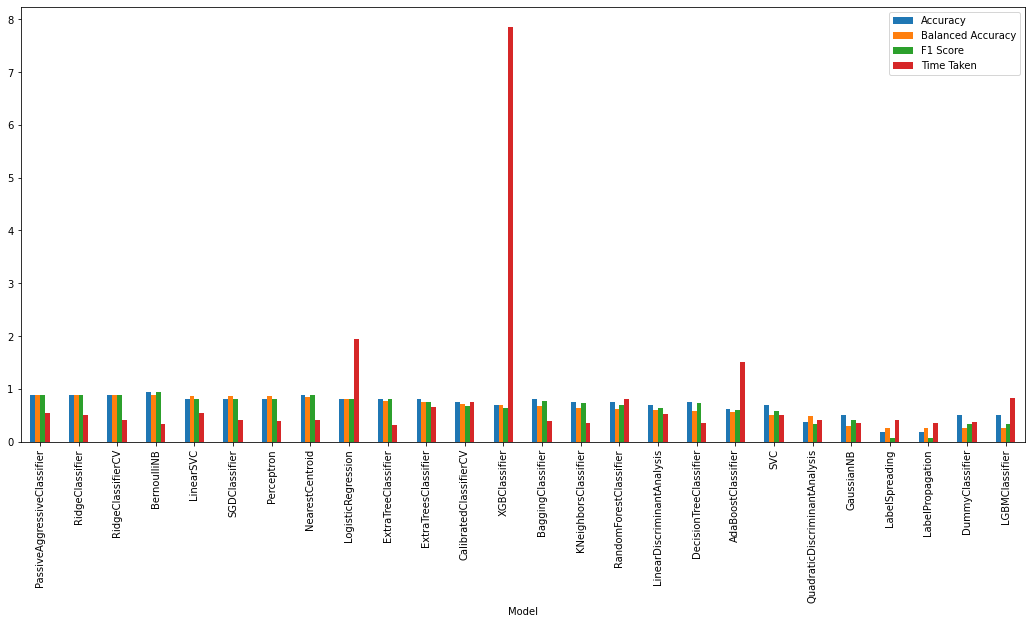

In [ ]:
models_c.plot.bar(figsize = (18,8));

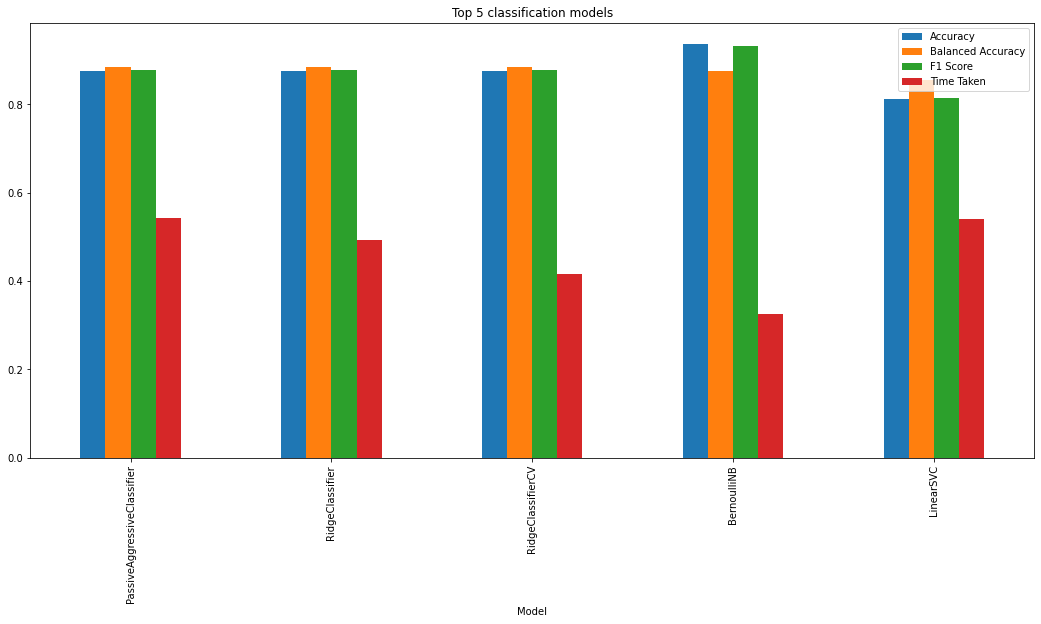

In [ ]:
models_c.iloc[0:5].plot.bar(figsize = (18,8), title="Top 5 classification models");

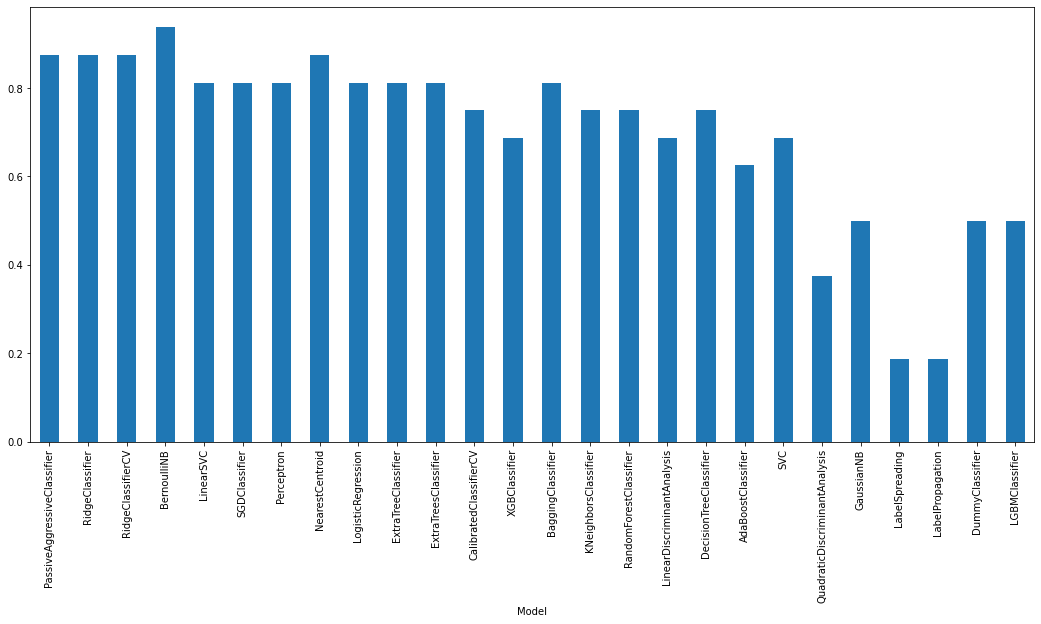

In [ ]:
models_c['Accuracy'].plot.bar(figsize = (18,8));

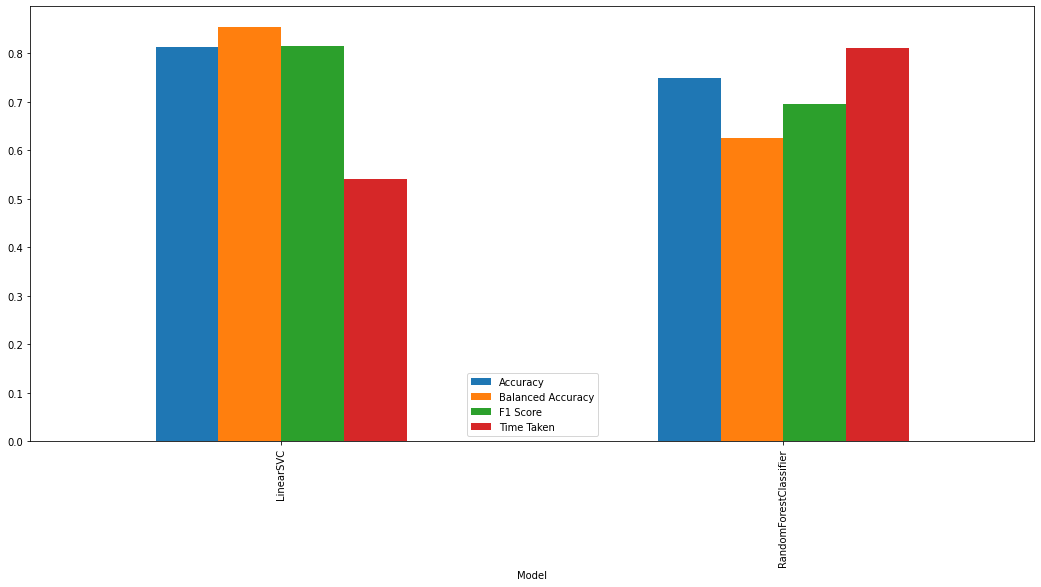

In [ ]:
models_c.loc[['LinearSVC','RandomForestClassifier']].plot.bar(figsize = (18,8));

In [ ]:
predictions_c

,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,...,PassiveAggressiveClassifier,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier
0,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.00,2.00,3.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
1,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.00,2.00,3.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
2,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.00,2.00,3.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
3,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
4,1.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00
5,1.00,1.00,0.00,1.00,1.00,2.00,0.00,1.00,2.00,0.00,...,0.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,2.00
6,1.00,1.00,1.00,3.00,0.00,2.00,3.00,3.00,2.00,1.00,...,3.00,3.00,3.00,1.00,3.00,3.00,3.00,2.00,3.00,2.00
7,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,...,2.00,2.00,0.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
8,3.00,0.00,3.00,3.00,0.00,2.00,0.00,3.00,2.00,1.00,...,3.00,3.00,1.00,3.00,3.00,3.00,3.00,1.00,3.00,2.00
9,1.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,2.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00
